In [21]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os

# fix random seed for reproducibility
seed = 2022
np.random.seed(seed)


# New Section

In [22]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D,Input
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE


2.17.0


In [23]:

from google.colab import drive
drive.mount('/content/drive')
#

##!ls '/content/gdrive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
data = pd.read_csv('/content/drive/My Drive/pcap/packets_per_sec_analysis.csv')

# Extract the column 'packets_per_sec'
data = data['packets_per_sec']

# Calculate the indices at which to split the data
train_split_index = int(len(data) * 0.45)
val_split_index = int(len(data) * 0.725)

# Split the data into training, validation, and test datasets
train_dataset = data[:train_split_index]
val_dataset = data[train_split_index:val_split_index]
test_dataset = data[val_split_index:]

print(train_dataset.shape)
print(val_dataset.shape)
print(test_dataset.shape)


(809,)
(494,)
(495,)


In [25]:
# Select the column 'packets_per_sec' as the feature for your model
features = ['packets_per_sec']

# train and validate
train_values = np.asarray(train_dataset.values, dtype=np.float32).reshape(-1, 1)
train_labels = np.asarray(train_dataset.values, dtype=np.float32)

val_values = np.asarray(val_dataset.values, dtype=np.float32).reshape(-1, 1)
val_labels = np.asarray(val_dataset.values, dtype=np.float32)

test_values = np.asarray(test_dataset.values, dtype=np.float32).reshape(-1, 1)
test_labels = np.asarray(test_dataset.values, dtype=np.float32)

In [26]:
# imports to show that there are many different scalers
# especially with recurrent NNs, the choice of scaler can make a difference
# look up what they do before choosing which one to try

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# Example: train standard scalers, apply to train and test data
# adapt to do all you need to do ...

SS1 = StandardScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)
test_scaled = SS1.transform(test_values)

In [27]:
# window-based and recurrent networks:

"""
This function creates a dataset for time-series analysis, specifically for window-based .

Parameters:
- features: A numpy array containing the input data for the model.
- labels: A numpy array containing the corresponding output data for the model.
- ahead: An integer that specifies how many steps ahead in the future the labels are. Default is 4.
- window_size: An integer that specifies the size of the sliding window that is used to create the input data.
- max_window_size: An integer that specifies the maximum size of the sliding window.

Returns:
- dataX: A 3D numpy array of shape (num_samples, window_size, num_features) containing the input data samples.
- labels: A 1D numpy array of shape (num_samples,) containing the corresponding labels for the input data samples.

The function calculates the number of samples that can be created based on the size of the features array, the 'ahead' parameter, and the 'max_window_size' parameter. It then creates a list of input data samples by sliding a window of size 'window_size' over the features array. Each input data sample is a 2D numpy array of shape (window_size, num_features), where 'num_features' is the number of features in the features array. The function returns a tuple containing two numpy arrays: the first is a 3D numpy array of shape (num_samples, window_size, num_features) containing the input data samples, and the second is a 1D numpy array of shape (num_samples,) containing the corresponding labels for the input data samples. The labels are shifted 'ahead' steps into the future, and only the labels that correspond to the input data samples are included in the output array.
"""

def create_dataset_windowed(features, labels, ahead=4, window_size=1, max_window_size=360):
    samples = features.shape[0] - ahead - (max_window_size - 1)
    window_size = min(max(window_size, 1), max_window_size)

    dataX = np.array([features[(i + max_window_size - window_size):(i + max_window_size), :] for i in range(samples)])
    dataY = labels[ahead + max_window_size - 1 : ahead + max_window_size - 1 + samples]

    return dataX, dataY

In [28]:
def PlotResults(labels, predictions, window_size, ahead, dataset_type=""):
    fig = plt.figure(figsize=(6, 4), dpi=300)  # Adjust the figure size for better clarity
    ax1 = fig.add_subplot(111)  # Create a single subplot

    # Plot the actual vs. predicted values
    ax1.plot(labels, 'k-', label='Observed traffic', linewidth=1)  # 'k-' for black line, representing actual data
    ax1.plot(predictions, 'r-', label='Predicted traffic', linewidth=1)  # 'r-' for red line, representing predicted data

    # Labeling the axes
    ax1.set_ylabel('Traffic (Packets per second)', fontsize=12)
    ax1.set_xlabel('Time (Seconds)', fontsize=12)
    # Add the legend for clarification
    ax1.legend(loc='upper right', fontsize=10)

    # Add a more descriptive title
    ax1.set_title(f"Comparison of Actual vs Predicted traffic\n"
                  f"Look-back period: {window_size} Seconds | Forecasting horizon: {ahead} Seconds", fontsize=14, pad=15)

    # Show the plot
    plt.tight_layout()  # Ensure everything fits without overlapping
    plt.show()

In [29]:
def plot_history(history):
  plt.figure(figsize = (6,4))

  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

Training model with window size: 120


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 120, 128)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 120, 128)            │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 120, 64)             │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 120, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 3840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │         245,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,249 (1.35 MB)

 Trainable params: 353,249 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - loss: 33.0469 - mae: 33.0469 - mse: 1274.6520 - val_loss: 30.6185 - val_mae: 30.6185 - val_mse: 1137.5480
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 32.3731 - mae: 32.3731 - mse: 1239.7427 - val_loss: 29.4835 - val_mae: 29.4835 - val_mse: 1069.3832
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 31.2001 - mae: 31.2001 - mse: 1170.6047 - val_loss: 26.6715 - val_mae: 26.6715 - val_mse: 911.4883
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 27.8142 - mae: 27.8142 - mse: 972.0317 - val_loss: 20.4766 - val_mae: 20.4766 - val_mse: 619.5245
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.9785 - mae: 20.9785 - mse: 632.1184 - val_loss: 11.0740 - val_mae: 11.0740 - val_mse: 260.9626
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 11.2621 - mae: 11.2621 - mse: 274.4056 - val_loss: 14.6459 - val_mae: 14.6459 - val_mse: 286.2560
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11

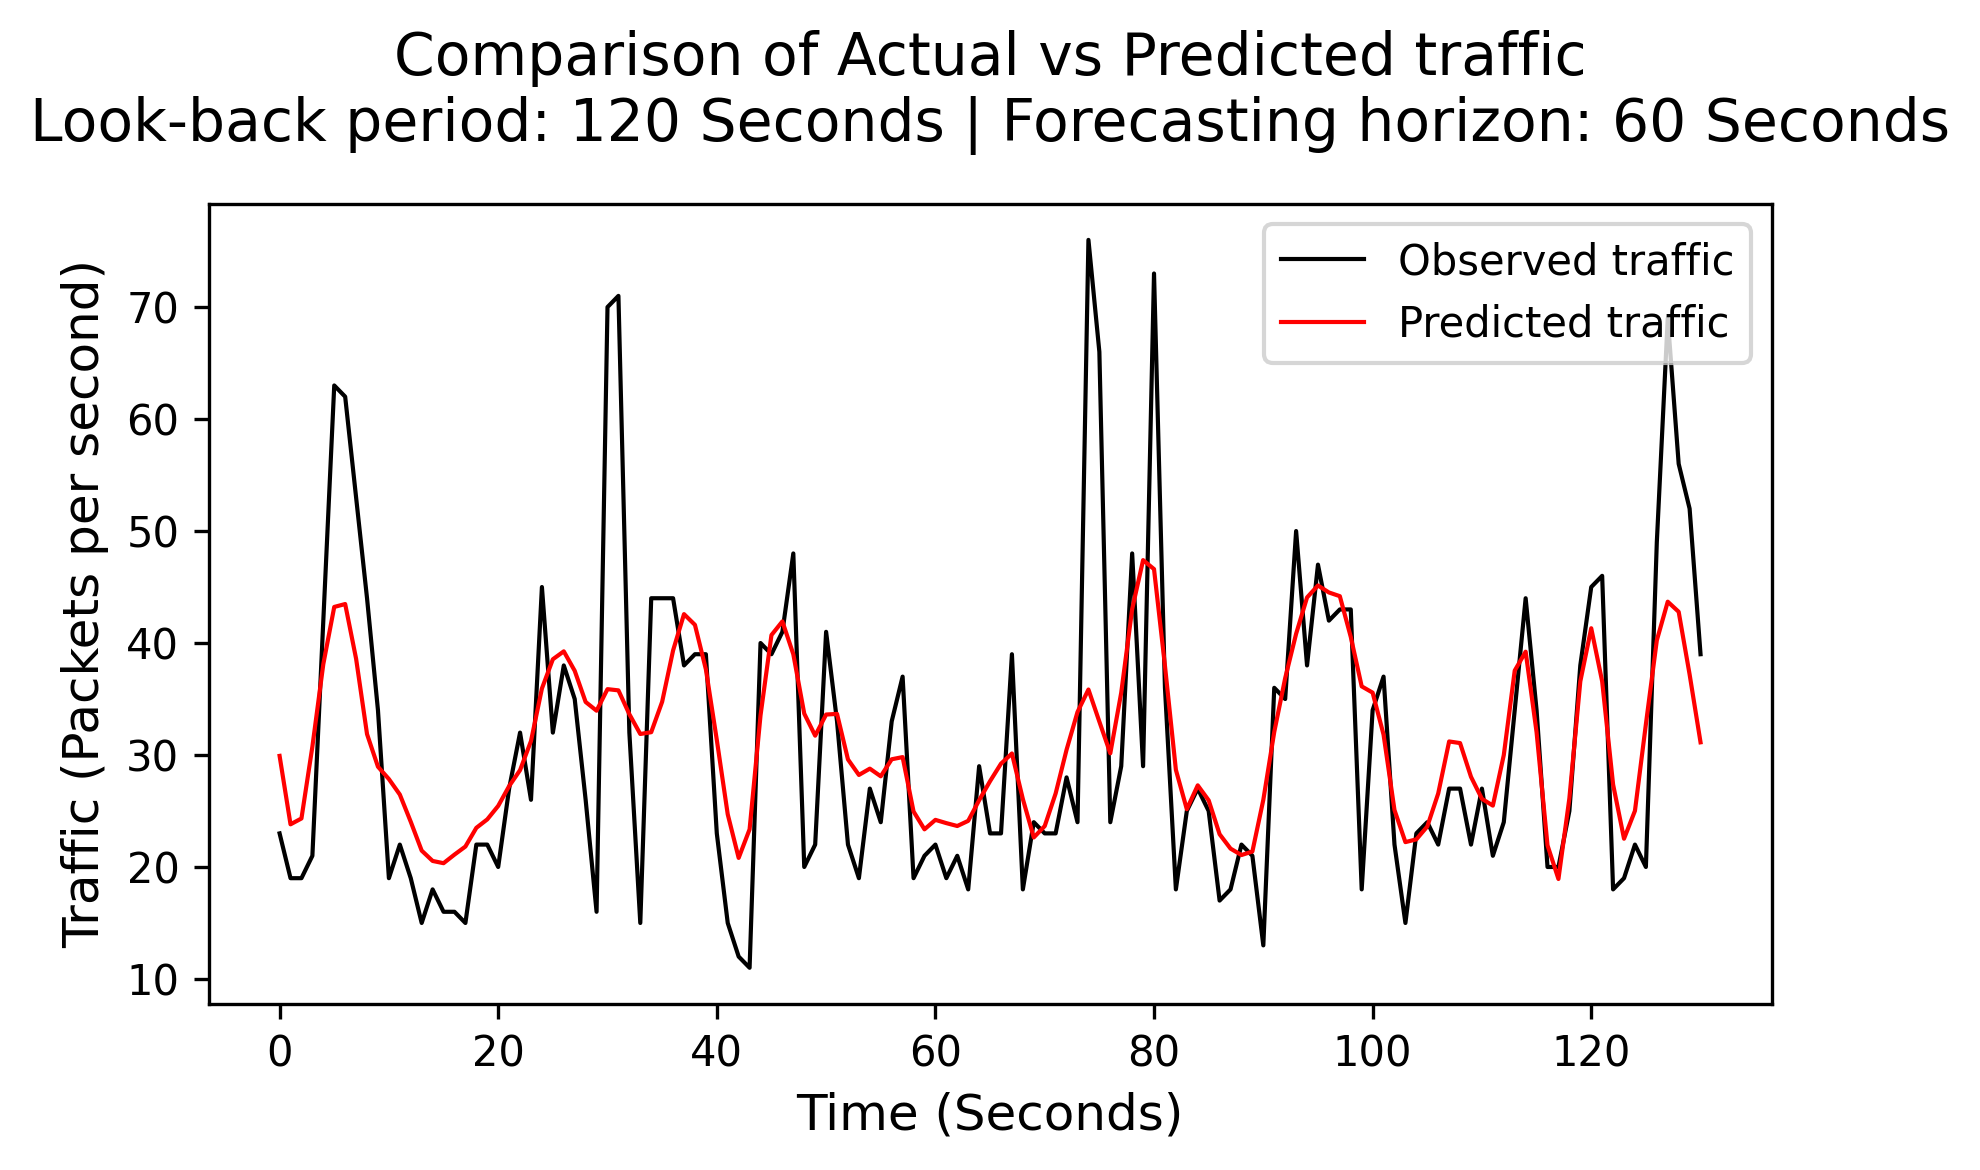

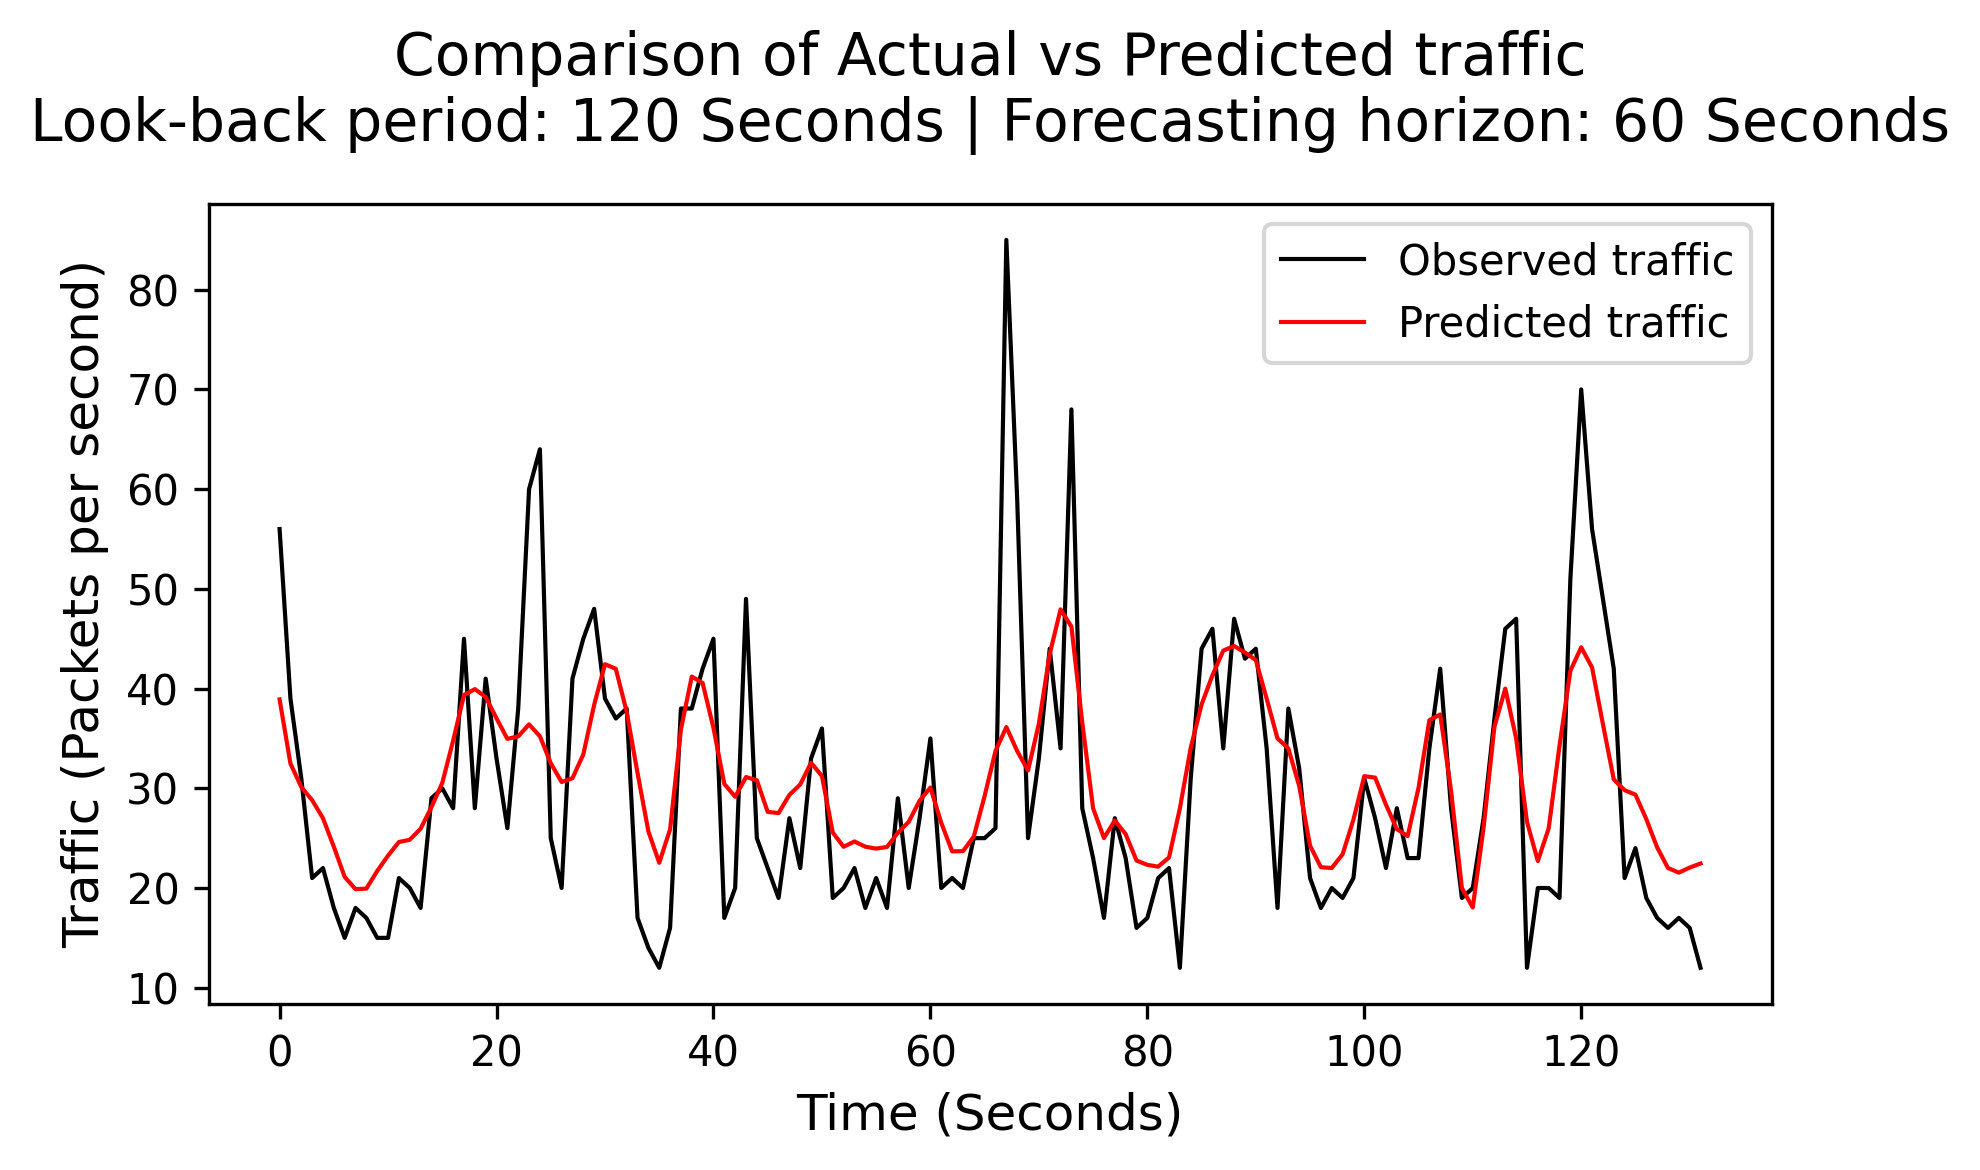

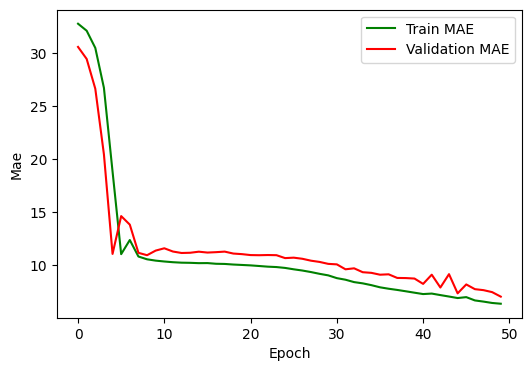

Training model with window size: 120


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)                   │ (None, 120, 128)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 120, 128)            │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 120, 64)             │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 120, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │         245,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,249 (1.35 MB)

 Trainable params: 353,249 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 32.4261 - mae: 32.4261 - mse: 1231.4561 - val_loss: 30.5515 - val_mae: 30.5515 - val_mse: 1133.0139
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 32.8092 - mae: 32.8092 - mse: 1274.9111 - val_loss: 29.4613 - val_mae: 29.4613 - val_mse: 1067.4338
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 31.2043 - mae: 31.2043 - mse: 1156.8822 - val_loss: 27.2309 - val_mae: 27.2309 - val_mse: 940.6166
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 28.4028 - mae: 28.4028 - mse: 974.1206 - val_loss: 22.9139 - val_mae: 22.9139 - val_mse: 723.4880
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 23.9881 - mae: 23.9881 - mse: 757.0605 - val_loss: 15.1545 - val_mae: 15.1545 - val_mse: 419.2434
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 15.6221 - mae: 15.6221 - mse: 409.9784 - val_loss: 11.2171 - val_mae: 11.2171 - val_mse: 196.3115
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11

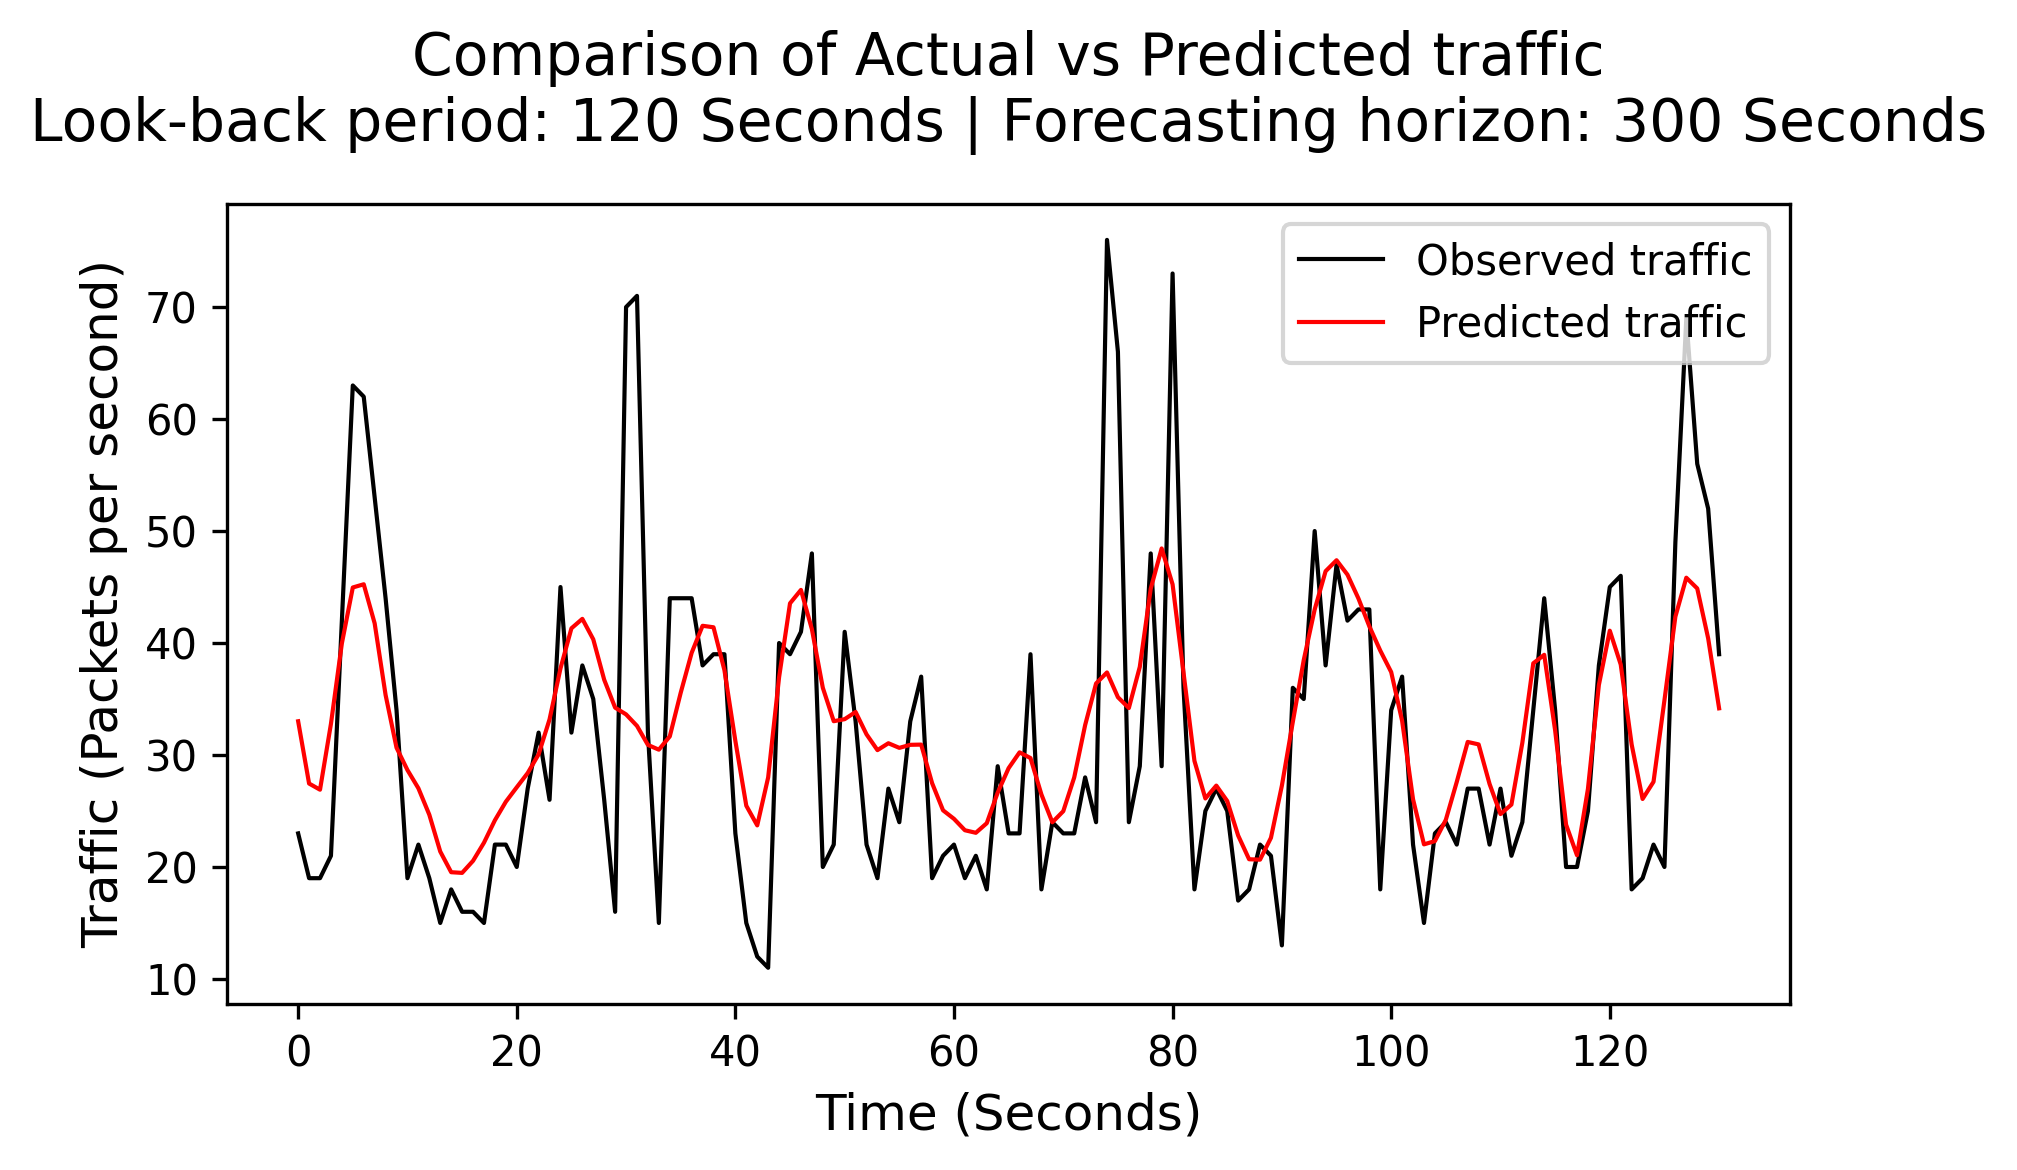

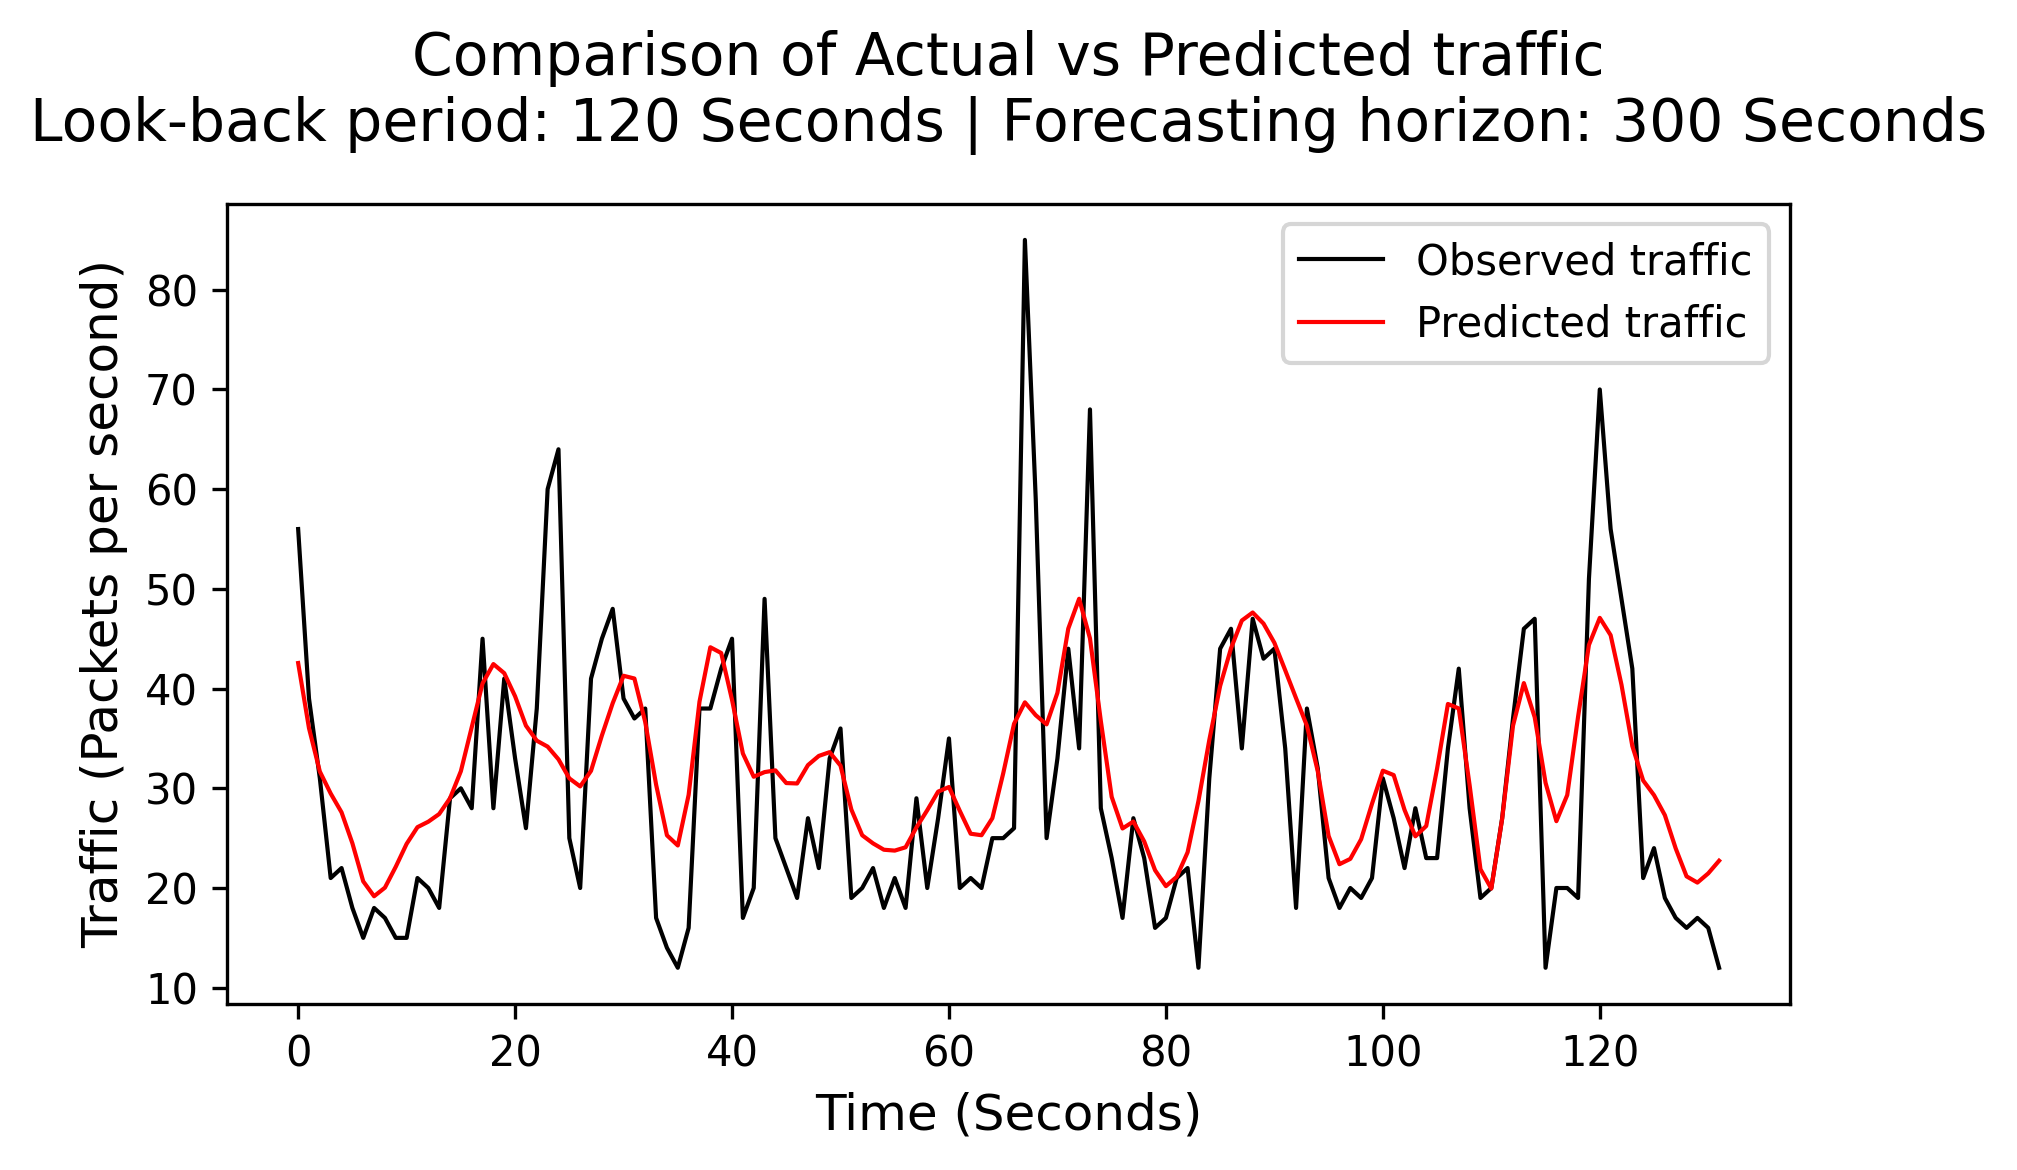

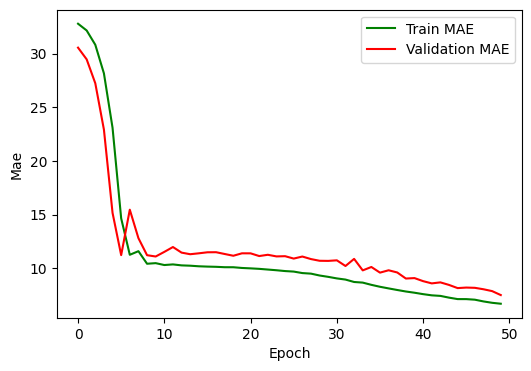

Training model with window size: 120


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)                   │ (None, 120, 128)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 120, 128)            │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, 120, 64)             │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, 120, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │         245,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,249 (1.35 MB)

 Trainable params: 353,249 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - loss: 33.9230 - mae: 33.9230 - mse: 1371.5968 - val_loss: 30.7751 - val_mae: 30.7751 - val_mse: 1147.1899
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 32.5248 - mae: 32.5248 - mse: 1230.2469 - val_loss: 29.9831 - val_mae: 29.9831 - val_mse: 1099.0541
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 31.6063 - mae: 31.6063 - mse: 1184.8325 - val_loss: 28.2547 - val_mae: 28.2547 - val_mse: 998.3792
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 29.3260 - mae: 29.3260 - mse: 1040.1953 - val_loss: 24.8496 - val_mae: 24.8496 - val_mse: 817.5106
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 25.9690 - mae: 25.9690 - mse: 876.8420 - val_loss: 18.3616 - val_mae: 18.3616 - val_mse: 535.8529
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 19.3120 - mae: 19.3120 - mse: 552.2790 - val_loss: 10.9221 - val_mae: 10.9221 - val_mse: 235.8448
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1

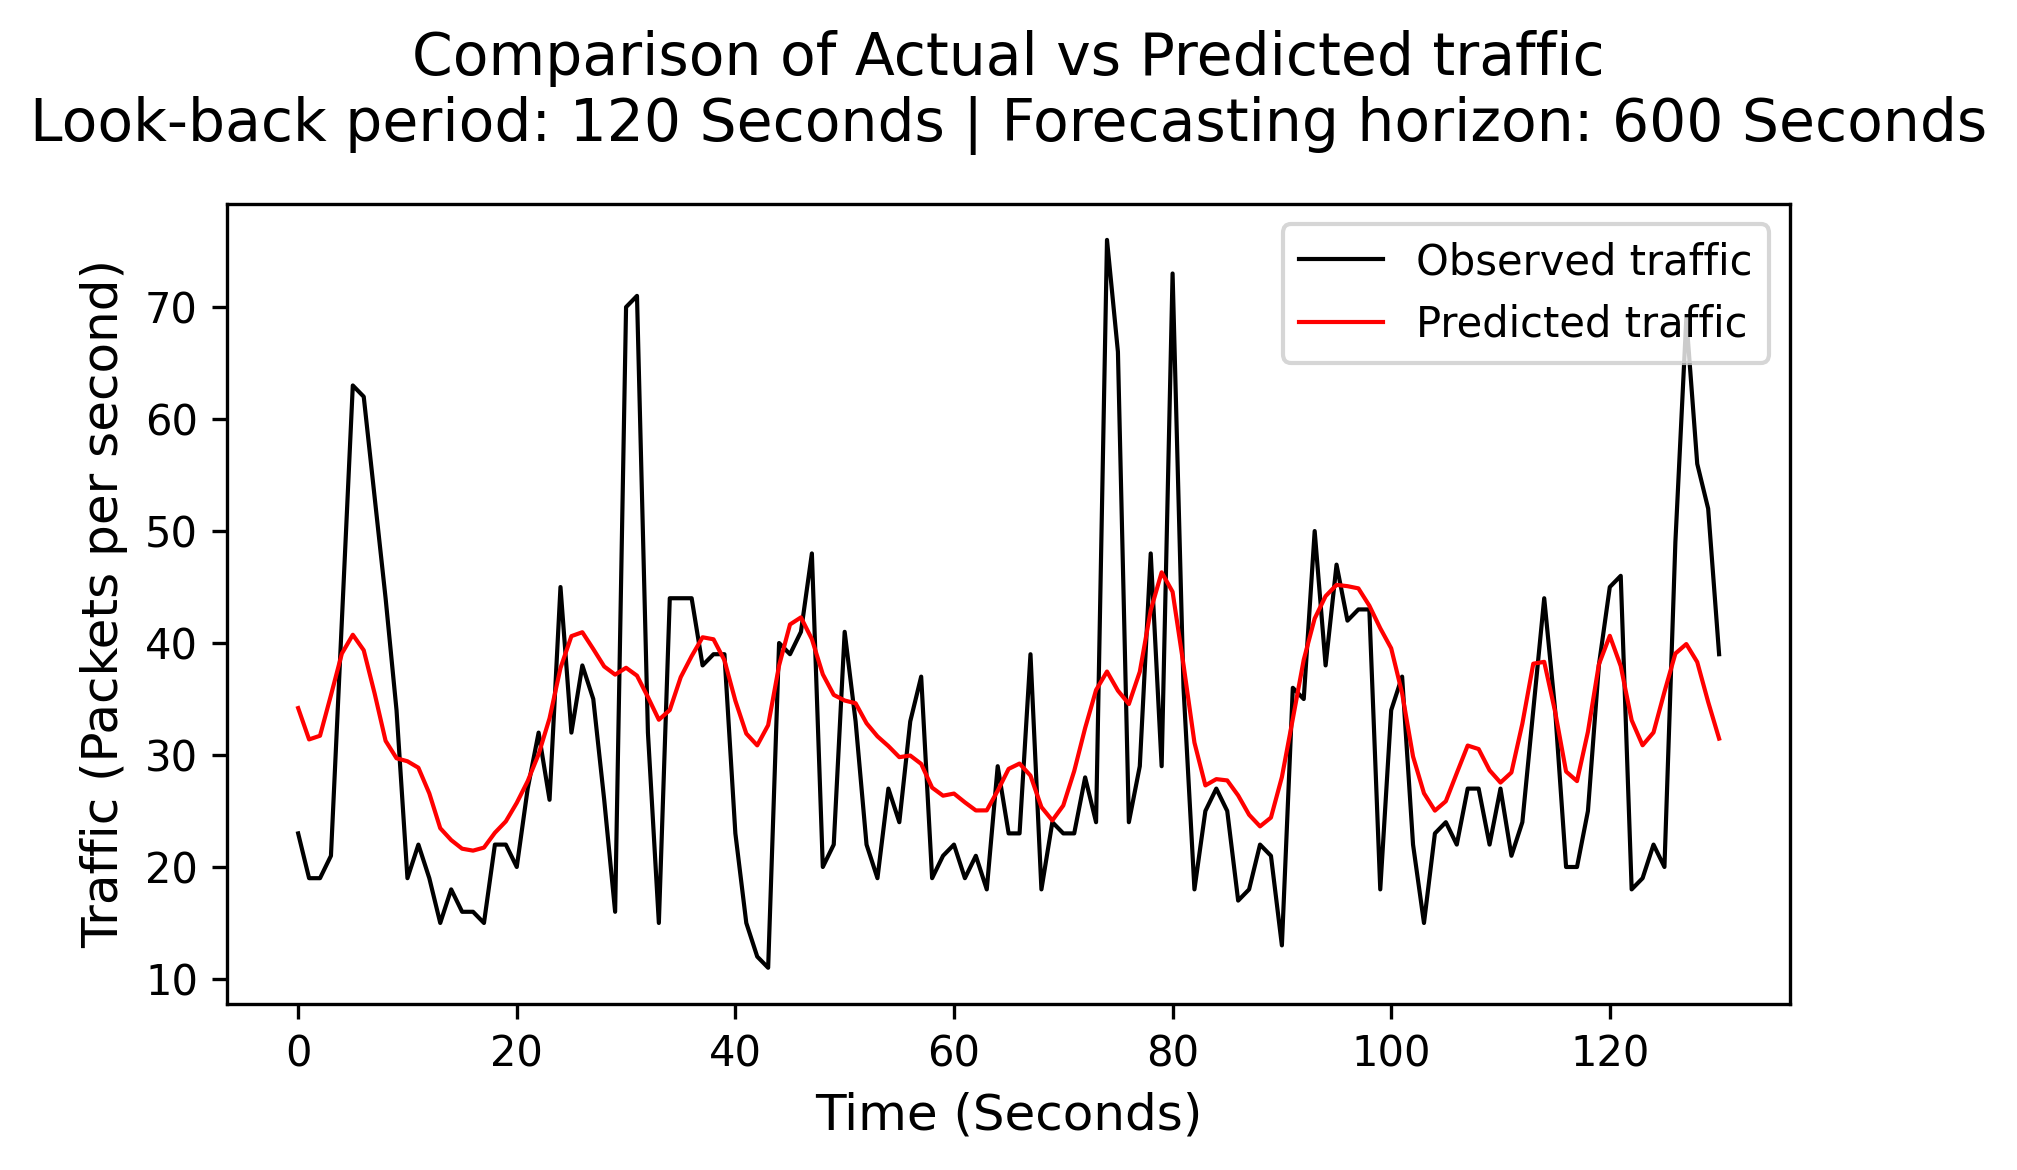

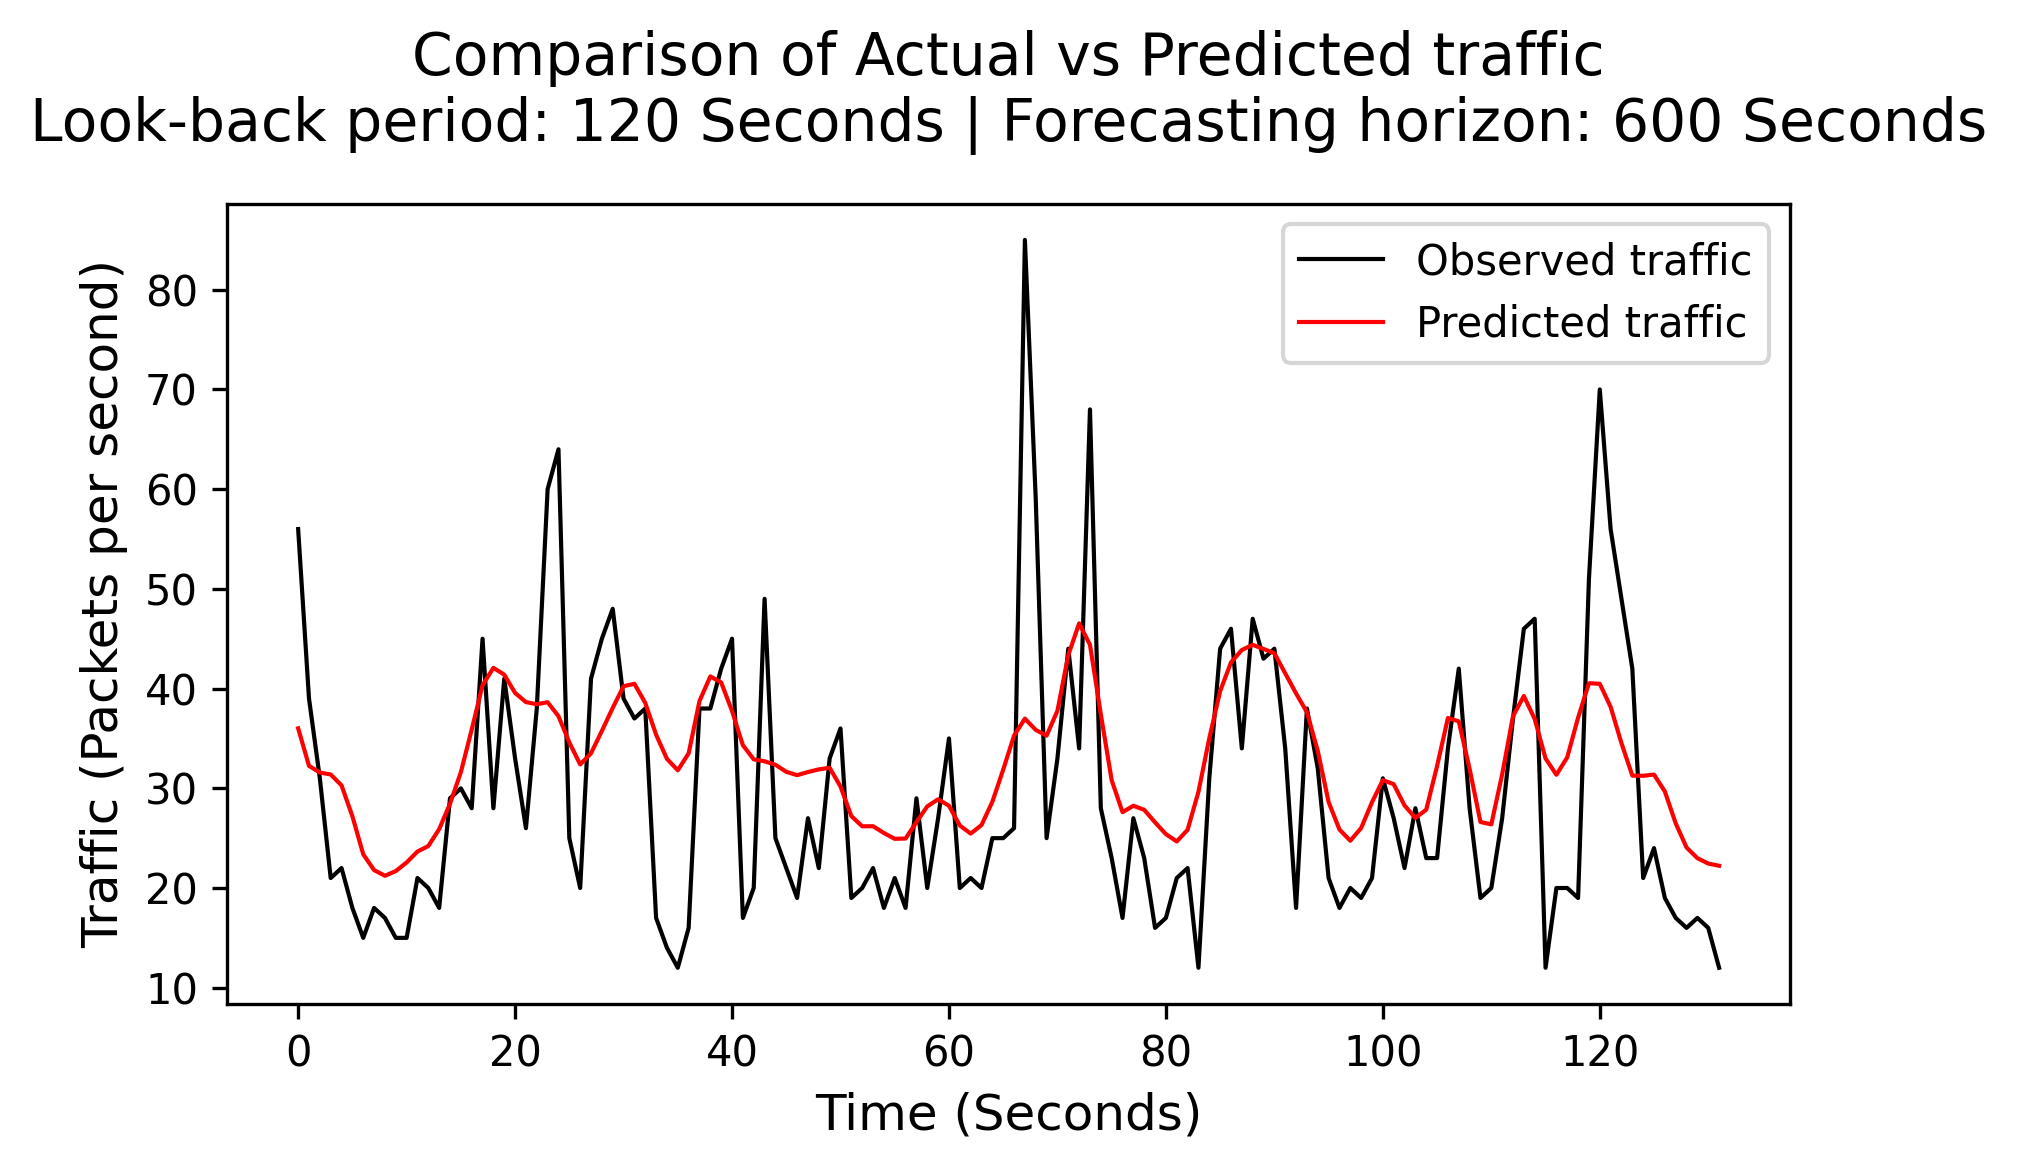

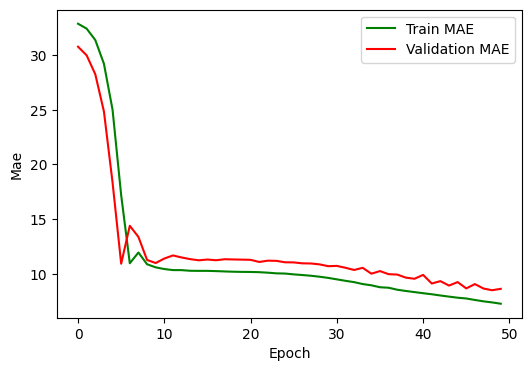

Loop stopped


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Activation
from tabulate import tabulate

"""
The script trains a CNN model with different window sizes for prediction.

The script uses the `create_dataset_windowed` function to create input data samples by sliding a window of size `window_size` over the features array.
The script then trains a CNN model with the input data samples and corresponding labels. The model is compiled with the Adam optimizer, mean absolute error (MAE) loss function, and MAE and MSE metrics.
The model is trained for 50 epochs with a batch size of 64. The training and validation MAE are calculated and stored in a pandas DataFrame.
The results are displayed as a table using the `tabulate` library and saved to a CSV file.

Parameters:
- window_sizes: A list of integers specifying the window sizes to use for training the model.
- train_scaled: A numpy array containing the scaled input data for training the model.
- train_labels: A numpy array containing the corresponding output data for training the model.
- val_scaled: A numpy array containing the scaled input data for validating the model.
- val_labels: A numpy array containing the corresponding output data for validating the model.

Returns:
- None
The script prints the model summary, training and validation MAE for each window size, and a table summarizing the results. The results are also saved to a CSV file.
"""

histories = {}

folder_path = '/content/drive/My Drive/pcap/'

# Defining window sizes and ahead values
window_sizes = [120]
ahead_values = [60, 300, 600]
"""
results = pd.DataFrame()

for WINDOW in window_sizes:
    for AHEAD in ahead_values:

        print(f"Training model with window size: {WINDOW}")

        X_train_w, r_train_w = create_dataset_windowed(train_scaled, train_labels, window_size=WINDOW)
        X_val_w, r_val_w = create_dataset_windowed(val_scaled, val_labels, window_size=WINDOW)
        X_test_w, r_test_w = create_dataset_windowed(test_scaled, test_labels, window_size=WINDOW)

        # Rebuild the model for each window size
        CNNmodel = Sequential()

        # Add input layer explicitly with Input()
        CNNmodel.add(Input(shape=(WINDOW, X_train_w.shape[-1])))

        CNNmodel.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
        CNNmodel.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
        CNNmodel.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
        CNNmodel.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))

        CNNmodel.add(Flatten())

        # Automatically handle the input size
        CNNmodel.add(Dense(64, activation='relu'))
        CNNmodel.add(Dense(1))
        CNNmodel.add(Activation('linear'))

        CNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae', metrics=['mae', 'mse'])

        # Print the model summary to check the shape
        print(CNNmodel.summary())

        batch_size = 64
        epochs = 50
        CNN_history = CNNmodel.fit(X_train_w, r_train_w,
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   verbose=1,
                                   validation_data=(X_val_w, r_val_w),
                                   shuffle=True)

        histories[WINDOW] = CNN_history.history

        y_train_CNNmodel = CNNmodel.predict(X_train_w)
        y_val_CNNmodel = CNNmodel.predict(X_val_w)
        y_test_CNNmodel = CNNmodel.predict(X_test_w)

        mae_train_CNNmodel = mean_absolute_error(r_train_w, y_train_CNNmodel)
        mae_val_CNNmodel = mean_absolute_error(r_val_w, y_val_CNNmodel)
        mae_test_CNNmodel = mean_absolute_error(r_test_w, y_test_CNNmodel)

        # Storing the results
        new_row = pd.DataFrame({
            'Window Size / Seconds in history': [WINDOW],
            'Ahead / Seconds in the future': [AHEAD],
            'Train MAE': [mae_train_CNNmodel],
            'Validation MAE': [mae_val_CNNmodel]
        })
        results = pd.concat([results, new_row], ignore_index=True)

        print(f"Window size: {WINDOW}, Ahead: {AHEAD}")
        print(f"Train MAE: {mae_train_CNNmodel}")
        print(f"Validation MAE: {mae_val_CNNmodel}")

        predictions_df = pd.DataFrame({
            'Actual': r_val_w.flatten(),
            'Predicted': y_val_CNNmodel.flatten()
        })
        predictions_df.to_csv(f'{folder_path}predictions_window_{WINDOW}_ahead_{AHEAD}.csv', index=False)

        PlotResults(r_val_w[:1000], y_val_CNNmodel[:1000, 0])
        PlotResults(r_test_w[:1000], y_test_CNNmodel[:1000, 0])
        plot_history(CNN_history)

results.to_csv(f'{folder_path}results_summary.csv', index=False)
print("Loop stopped")

results = pd.DataFrame()

for WINDOW in window_sizes:
    for AHEAD in ahead_values:

        print(f"Training model with window size: {WINDOW}")

        X_train_w, r_train_w = create_dataset_windowed(train_scaled, train_labels, window_size=WINDOW)
        X_val_w, r_val_w = create_dataset_windowed(val_scaled, val_labels, window_size=WINDOW)
        X_test_w, r_test_w = create_dataset_windowed(test_scaled, test_labels, window_size=WINDOW)

        # Rebuild the model for each window size
        CNNmodel = Sequential()

        # Add input layer explicitly with Input()
        CNNmodel.add(Input(shape=(WINDOW, X_train_w.shape[-1])))

        CNNmodel.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
        CNNmodel.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
        CNNmodel.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
        CNNmodel.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))

        CNNmodel.add(Flatten())

        # Automatically handle the input size
        CNNmodel.add(Dense(64, activation='relu'))
        CNNmodel.add(Dense(1))
        CNNmodel.add(Activation('linear'))

        CNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae', metrics=['mae', 'mse'])

        # Print the model summary to check the shape
        print(CNNmodel.summary())

        batch_size = 64
        epochs = 50
        CNN_history = CNNmodel.fit(X_train_w, r_train_w,
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   verbose=1,
                                   validation_data=(X_val_w, r_val_w),
                                   shuffle=True)

        histories[WINDOW] = CNN_history.history

        y_val_CNNmodel = CNNmodel.predict(X_val_w)
        y_test_CNNmodel = CNNmodel.predict(X_test_w)

        mae_val_CNNmodel = mean_absolute_error(r_val_w, y_val_CNNmodel)
        mae_test_CNNmodel = mean_absolute_error(r_test_w, y_test_CNNmodel)

        # Storing the results
        new_row = pd.DataFrame({
            'Look-back Period (Seconds)': [WINDOW],
            'Forecasting horizon (Seconds)': [AHEAD],
            'Validation MAE': [mae_val_CNNmodel],
            'Test MAE': [mae_test_CNNmodel]
        })
        results = pd.concat([results, new_row], ignore_index=True)

        print(f"Window size: {WINDOW}, Ahead: {AHEAD}")
        print(f"Validation MAE: {mae_val_CNNmodel}")
        print(f"Test MAE: {mae_test_CNNmodel}")

        predictions_df = pd.DataFrame({
            'Actual': r_val_w.flatten(),
            'Predicted': y_val_CNNmodel.flatten()
        })
        predictions_df.to_csv(f'{folder_path}predictions_val_window_{WINDOW}_ahead_{AHEAD}.csv', index=False)

        predictions_test_df = pd.DataFrame({
            'Actual': r_test_w.flatten(),
            'Predicted': y_test_CNNmodel.flatten()
        })
        predictions_test_df.to_csv(f'{folder_path}predictions_test_window_{WINDOW}_ahead_{AHEAD}.csv', index=False)

        PlotResults(r_val_w[:1000], y_val_CNNmodel[:1000, 0], WINDOW, AHEAD, dataset_type="Validation")

        PlotResults(r_test_w[:1000], y_test_CNNmodel[:1000, 0], WINDOW, AHEAD, dataset_type="Test")
        plot_history(CNN_history)

results.to_csv(f'{folder_path}results_summary.csv', index=False)
print("Loop stopped")
"""
mae_results = pd.DataFrame()
mse_results = pd.DataFrame()
rmse_results = pd.DataFrame()

for WINDOW in window_sizes:
    for AHEAD in ahead_values:

        print(f"Training model with window size: {WINDOW}")

        X_train_w, r_train_w = create_dataset_windowed(train_scaled, train_labels, window_size=WINDOW)
        X_val_w, r_val_w = create_dataset_windowed(val_scaled, val_labels, window_size=WINDOW)
        X_test_w, r_test_w = create_dataset_windowed(test_scaled, test_labels, window_size=WINDOW)

        # Rebuild the model for each window size
        CNNmodel = Sequential()

        # Add input layer explicitly with Input()
        CNNmodel.add(Input(shape=(WINDOW, X_train_w.shape[-1])))

        CNNmodel.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
        CNNmodel.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
        CNNmodel.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
        CNNmodel.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))

        CNNmodel.add(Flatten())

        # Automatically handle the input size
        CNNmodel.add(Dense(64, activation='relu'))
        CNNmodel.add(Dense(1))
        CNNmodel.add(Activation('linear'))

        CNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae', metrics=['mae', 'mse'])

        # Print the model summary to check the shape
        print(CNNmodel.summary())

        batch_size = 64
        epochs = 50
        CNN_history = CNNmodel.fit(X_train_w, r_train_w,
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   verbose=1,
                                   validation_data=(X_val_w, r_val_w),
                                   shuffle=True)

        histories[WINDOW] = CNN_history.history

        y_val_CNNmodel = CNNmodel.predict(X_val_w)
        y_test_CNNmodel = CNNmodel.predict(X_test_w)

        # Calculate MAE
        mae_val_CNNmodel = mean_absolute_error(r_val_w, y_val_CNNmodel)
        mae_test_CNNmodel = mean_absolute_error(r_test_w, y_test_CNNmodel)

        # Calculate MSE
        mse_val_CNNmodel = mean_squared_error(r_val_w, y_val_CNNmodel)
        mse_test_CNNmodel = mean_squared_error(r_test_w, y_test_CNNmodel)

        # Calculate RMSE
        rmse_val_CNNmodel = np.sqrt(mse_val_CNNmodel)
        rmse_test_CNNmodel = np.sqrt(mse_test_CNNmodel)

        # Storing the MAE results
        mae_new_row = pd.DataFrame({
            'Look-back Period (Seconds)': [WINDOW],
            'Forecasting horizon (Seconds)': [AHEAD],
            'Validation MAE': [mae_val_CNNmodel],
            'Test MAE': [mae_test_CNNmodel]
        })
        mae_results = pd.concat([mae_results, mae_new_row], ignore_index=True)

        # Storing the MSE results
        mse_new_row = pd.DataFrame({
            'Look-back Period (Seconds)': [WINDOW],
            'Forecasting horizon (Seconds)': [AHEAD],
            'Validation MSE': [mse_val_CNNmodel],
            'Test MSE': [mse_test_CNNmodel]
        })
        mse_results = pd.concat([mse_results, mse_new_row], ignore_index=True)

        # Storing the RMSE results
        rmse_new_row = pd.DataFrame({
            'Look-back Period (Seconds)': [WINDOW],
            'Forecasting horizon (Seconds)': [AHEAD],
            'Validation RMSE': [rmse_val_CNNmodel],
            'Test RMSE': [rmse_test_CNNmodel]
        })
        rmse_results = pd.concat([rmse_results, rmse_new_row], ignore_index=True)

        # Printing the results
        print(f"Window size: {WINDOW}, Ahead: {AHEAD}")
        print(f"Validation MAE: {mae_val_CNNmodel}, Test MAE: {mae_test_CNNmodel}")
        print(f"Validation MSE: {mse_val_CNNmodel}, Test MSE: {mse_test_CNNmodel}")
        print(f"Validation RMSE: {rmse_val_CNNmodel}, Test RMSE: {rmse_test_CNNmodel}")

        # Save predictions to CSV
        predictions_df = pd.DataFrame({
            'Actual': r_val_w.flatten(),
            'Predicted': y_val_CNNmodel.flatten()
        })
        predictions_df.to_csv(f'{folder_path}predictions_val_window_{WINDOW}_ahead_{AHEAD}.csv', index=False)

        predictions_test_df = pd.DataFrame({
            'Actual': r_test_w.flatten(),
            'Predicted': y_test_CNNmodel.flatten()
        })
        predictions_test_df.to_csv(f'{folder_path}predictions_test_window_{WINDOW}_ahead_{AHEAD}.csv', index=False)

        # Plot results and history
        PlotResults(r_val_w[:1000], y_val_CNNmodel[:1000, 0], WINDOW, AHEAD, dataset_type="Validation")
        PlotResults(r_test_w[:1000], y_test_CNNmodel[:1000, 0], WINDOW, AHEAD, dataset_type="Test")
        plot_history(CNN_history)

# Save MAE, MSE, and RMSE results to CSV files
mae_results.to_csv(f'{folder_path}mae_results_summary.csv', index=False)
mse_results.to_csv(f'{folder_path}mse_results_summary.csv', index=False)
rmse_results.to_csv(f'{folder_path}rmse_results_summary.csv', index=False)

print("Loop stopped")